In [1]:
import numpy as np
import pandas as pd
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.io.ase import AseAtomsAdaptor
from multiprocessing import Pool, cpu_count
from ase import Atoms

# Load the saved dataframe
df = pd.read_pickle(f"../dataset/openmx_data_20250319_152811.pkl")

# Rename the 'structure' column to 'symmetrized_structure'
df = df.rename(columns={'structure': 'symmetrized_structure'})

# Exclude any structures containing Lutetium (Lu)
df['species'] = df['symmetrized_structure'].map(lambda x: list(set(x.get_chemical_symbols())))
df = df[df['species'].apply(lambda sp_list: 'Lu' not in sp_list)].reset_index(drop=True)

def compute_symmetrized_permittivity(row):
    """
    Computes the symmetrized permittivity tensor by averaging over all symmetry operations.
    Also extracts the crystal system, stores all rotation matrices, and returns the refined structure
    as a standard ASE Atoms object.
    """
    sym_prec = 1e-2

    # Extract structure and symmetry operations
    sga_primitive = SpacegroupAnalyzer(AseAtomsAdaptor.get_structure(row.symmetrized_structure), symprec=sym_prec)
    refined_structure = sga_primitive.get_refined_structure()
    refined_sga = SpacegroupAnalyzer(refined_structure, symprec=sym_prec)

    # Convert the refined structure to an ASE Atoms object
    # First, use AseAtomsAdaptor to get an intermediate Atoms-like object
    intermediate_atoms = AseAtomsAdaptor.get_atoms(refined_structure)

    # Explicitly create a new ASE Atoms object to avoid MSONAtoms or other subclasses
    refined_ase_atoms = Atoms(
        symbols=intermediate_atoms.get_chemical_symbols(),
        positions=intermediate_atoms.get_positions(),
        cell=intermediate_atoms.get_cell(),
        pbc=intermediate_atoms.get_pbc()
    )

    symmetry_operations = refined_sga.get_symmetry_operations(cartesian=True)

    # Extract crystal system
    crystal_system = refined_sga.get_crystal_system()  # Get crystal system name

    # Extract real and imaginary permittivity tensors
    re_matrix = row.real_Permittivity_Matrices
    im_matrix = row.imag_Permittivity_Matrices
    
    # Get all rotation matrices (do not remove duplicates)
    rotation_matrices = np.array([op.rotation_matrix for op in symmetry_operations])

    # Initialize arrays for symmetrized tensors
    aux = np.zeros_like(re_matrix)
    aux2 = np.zeros_like(im_matrix)

    # Vectorized computation over frequency points
    for i in range(len(re_matrix)):  # Loop over frequency points
        rotated_matrices_re = np.array([R @ re_matrix[i] @ R.T for R in rotation_matrices])  # Apply symmetry
        rotated_matrices_im = np.array([R @ im_matrix[i] @ R.T for R in rotation_matrices])  # Apply symmetry
        aux[i] = np.mean(rotated_matrices_re, axis=0)  # Average over all symmetries
        aux2[i] = np.mean(rotated_matrices_im, axis=0)  # Average over all symmetries

    return aux, aux2, crystal_system, rotation_matrices, refined_ase_atoms

# Use multiprocessing to parallelize over all rows in the dataframe
num_workers = min(cpu_count(), len(df))  # Limit workers to available CPU cores

with Pool(processes=num_workers) as pool:
    results = pool.map(compute_symmetrized_permittivity, [row for _, row in df.iterrows()])

# Store the results in the dataframe
df["real_symmetrized_permittivity"], df["imag_symmetrized_permittivity"], df["crystal_system"], df["rotation_matrices"], df["symmetrized_structure"] = zip(*results)

# Save the optimized dataframe
df.to_pickle(f"../dataset/symmetrized_permittivity_pruned.pkl")

# Print confirmation
print("Symmetry constraints applied in parallel, rotation matrices stored, structures refined as standard ASE Atoms objects, and results saved successfully.")
print("Crystal system, rotation matrices, and refined structures extracted and stored.")

/home/angush/miniconda3/envs/mp_api/lib/python3.9/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/home/angush/miniconda3/envs/mp_api/lib/python3.9/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/home/angush/miniconda3/envs/mp_api/lib/python3.9/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/home/angush/miniconda3/envs/mp_api/lib/python3.9/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/home/angush/miniconda3/

Symmetry constraints applied in parallel, rotation matrices stored, structures refined as standard ASE Atoms objects, and results saved successfully.
Crystal system, rotation matrices, and refined structures extracted and stored.


In [2]:
df.head()

,folder,formula,symmetrized_structure,mp_id,bandgap,crystal_system,omega,real_Permittivity_Matrices,imag_Permittivity_Matrices,Re_00,...,Im_12,Im_20,Im_21,Im_22,avg_re_trace,avg_im_trace,species,real_symmetrized_permittivity,imag_symmetrized_permittivity,rotation_matrices
0,/global/cfs/cdirs/m225/angush/materialProject/...,Li4Se8Y4,"(Atom('Li', [2.8385500000000006, 0.0, 2.88335]...",mp-37879,1.6604,tetragonal,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[[[3.481281668892605, -1.3506806366681457e-09,...","[[[-1.0722568410351282e-17, -2.371619162135055...","[3.481281668892605, 3.4813019889159484, 3.4813...",...,"[-6.400276971094875e-19, 1.187453653061564e-12...","[1.3823342267093493e-17, 1.882754707806698e-12...","[-6.400276971094875e-19, 1.187453653061564e-12...","[3.342549740214423e-18, 0.0001803350567406132,...","[3.4405690641171667, 3.44058861685612, 3.44064...","[-7.234861265325764e-18, 0.0001957028760583553...","[Y, Se, Li]","[[[3.4812758467294405, 0.0, -2.584939414228211...","[[[-1.2523566768095863e-17, 0.0, -4.8148248609...","[[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0,..."
1,/global/cfs/cdirs/m225/angush/materialProject/...,Mo3S2Se4,"(Atom('Mo', [1.6365999999999998, 0.94489145055...",mp-1025906,0.5619,trigonal,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[[[5.126763705823415, -0.0036857171285808207, ...","[[[3.2316203633511406e-17, 4.065761255667405e-...","[5.126763705823415, 5.1268254576594545, 5.1270...",...,"[2.6785699480178126e-17, -7.1566796821889846e-...","[-9.092746101489361e-19, 1.2366187483073555e-0...","[2.6785699480178126e-17, -7.1566796821889846e-...","[5.356300432663947e-18, 0.00011878724682517897...","[4.321433518069999, 4.321478600797114, 4.32161...","[1.9282726697651513e-17, 0.0004517163617600133...","[S, Mo, Se]","[[[5.124538605076387, 6.794333614242494e-18, 5...","[[[2.6245939830145304e-17, -2.5679065925163146...","[[[1.0, 3.969365967485894e-18, 0.0], [0.0, 1.0..."
2,/global/cfs/cdirs/m225/angush/materialProject/...,Li3NbS4,"(Atom('Li', [0.0, 0.0, 3.0251], index=0), Atom...",mp-755309,2.8348,cubic,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[[[1.7313146368871726, 7.054466462945285e-06, ...","[[[2.9669125906530276e-18, 2.117513176816877e-...","[1.7313146368871726, 1.7313217564659527, 1.731...",...,"[-1.0033425582785427e-17, 8.405343317085762e-1...","[3.969580319788735e-18, 8.535424337320327e-10,...","[-1.0033425582785427e-17, 8.405343317085762e-1...","[-6.4642318455671115e-18, 7.12408590969345e-05...","[1.7313150452437125, 1.7313221648231247, 1.731...","[9.731758164650026e-19, 7.124085259360446e-05,...","[Nb, S, Li]","[[[1.7313150452437125, -3.529303946892918e-23,...","[[[9.73175816465002e-19, 0.0, 0.0], [0.0, 9.73...","[[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0,..."
3,/global/cfs/cdirs/m225/angush/materialProject/...,CdSe2Zn,"(Atom('Zn', [2.07525, 2.07525, 2.981], index=0...",mp-1017534,0.7236,tetragonal,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[[[3.2667371759234984, -3.486898178425755e-06,...","[[[-1.7162171221554744e-17, -4.972084285417574...","[3.2667371759234984, 3.266768077328808, 3.2668...",...,"[-5.716867411329558e-18, 1.0499994209043163e-0...","[4.710222018194405e-18, 5.8322763388424595e-09...","[-5.716867411329558e-18, 1.0499994209043163e-0...","[-1.5461680231046413e-17, 0.000264086382651040...","[3.270700626888884, 3.270730008788789, 3.27081...","[-1.1048250663480898e-17, 0.000294768918248031...","[Se, Zn, Cd]","[[[3.2667200732203123, 0.0, 0.0], [0.0, 3.2667...","[[[-8.841535879698145e-18, 0.0, -9.62964972193...","[[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0,..."
4,/global/cfs/cdirs/m225/angush/materialProject/...,Al8Te12,"(Atom('Al', [-1.0110162555088607, 0.7063003620...",mp-1228524,1.3222,monoclinic,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[[[3.57865600493003, -2.773634699822434e-08, 0...","[[[-2.370171074423322e-18, -5.455394216331598e...","[3.57865600493003, 3.5786781470220483, 3.57874...",...,"[-2.455824835482616e-18, 3.9216660381713

/home/angush/miniconda3/envs/mp_api/lib/python3.9/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(


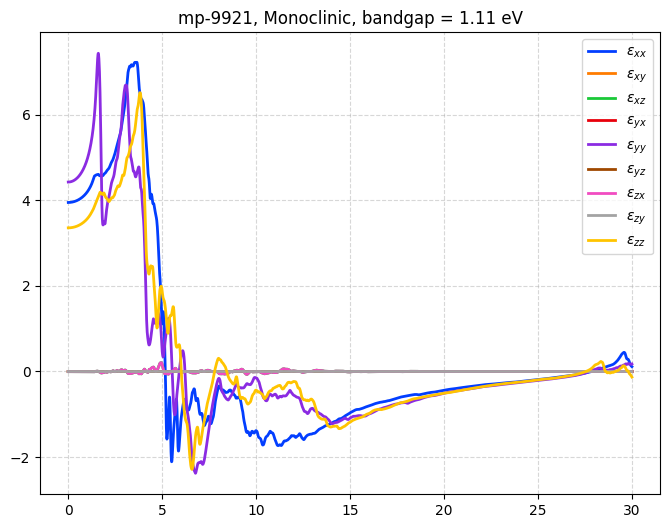

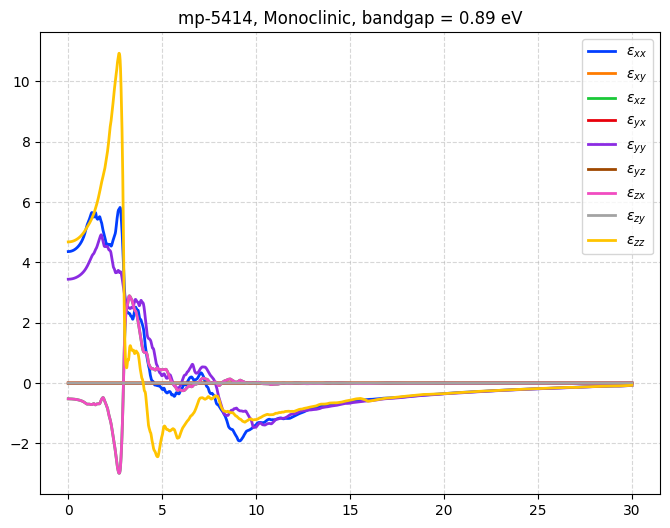

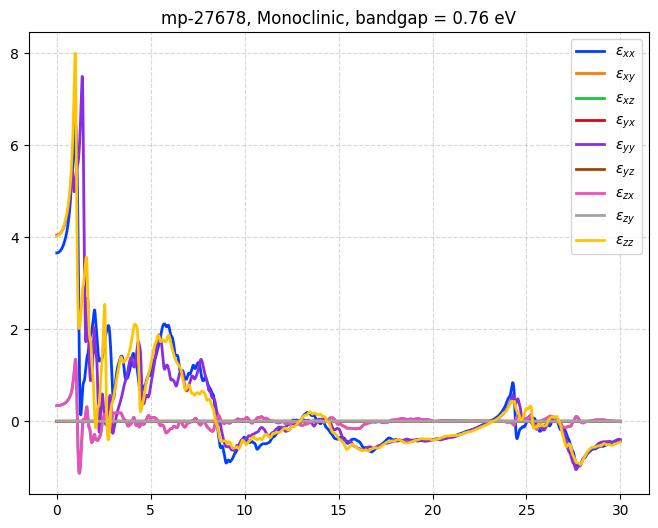

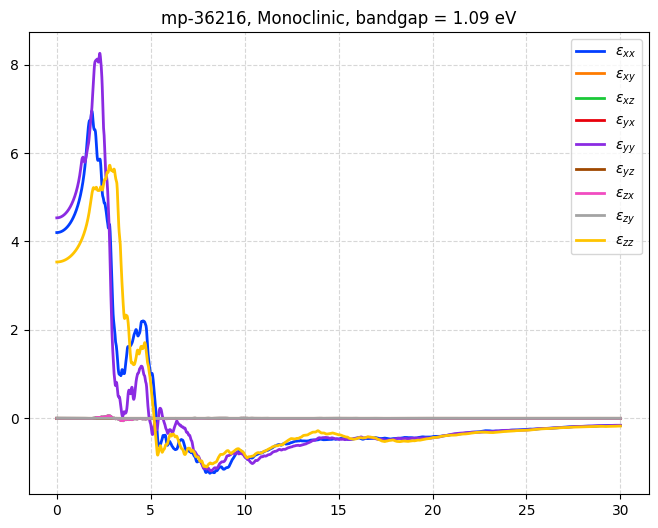

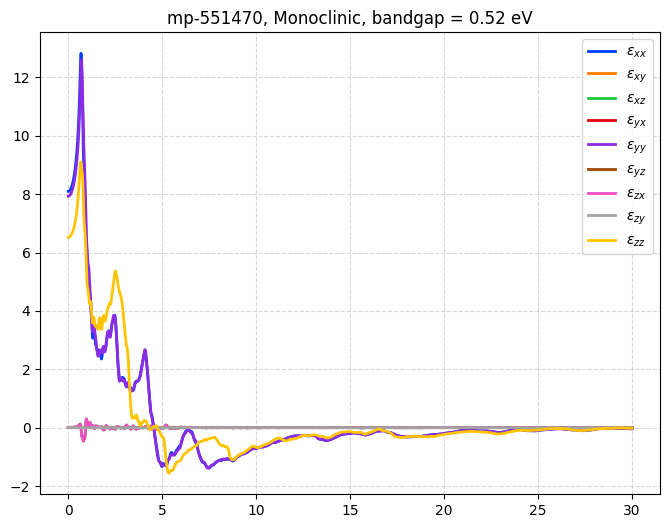

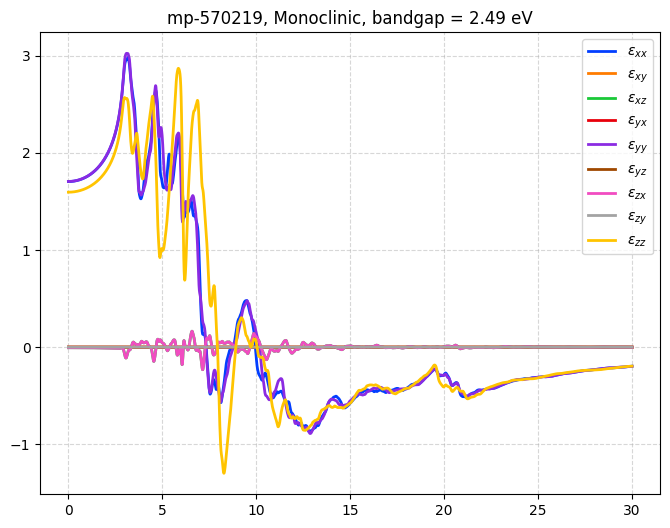

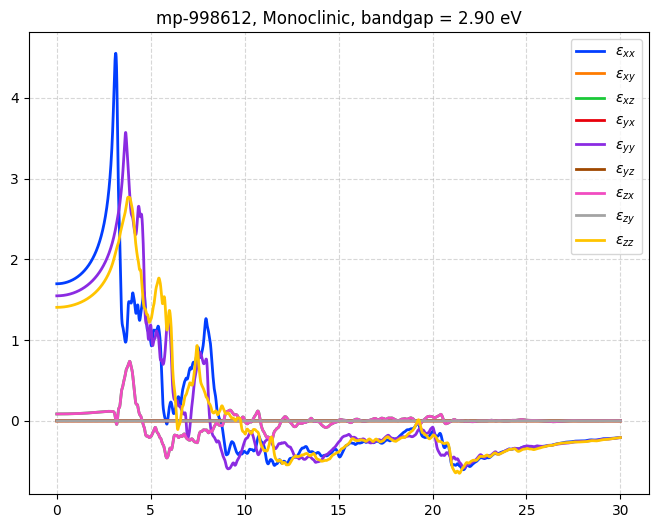

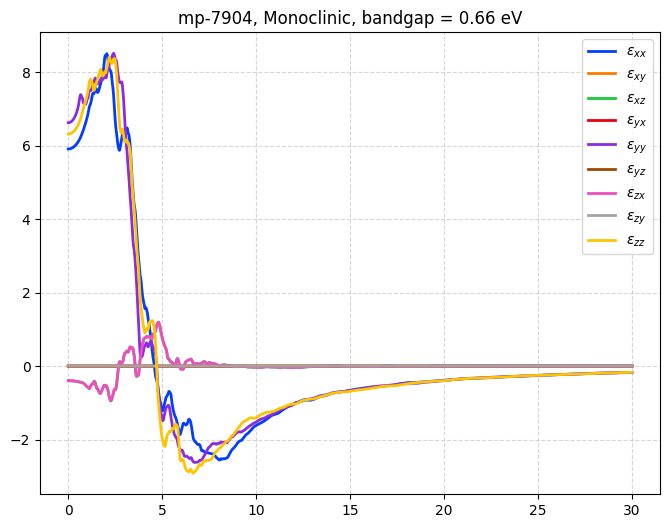

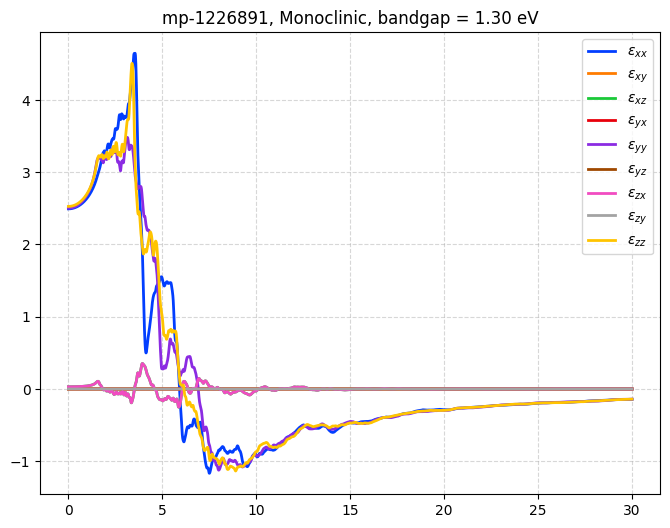

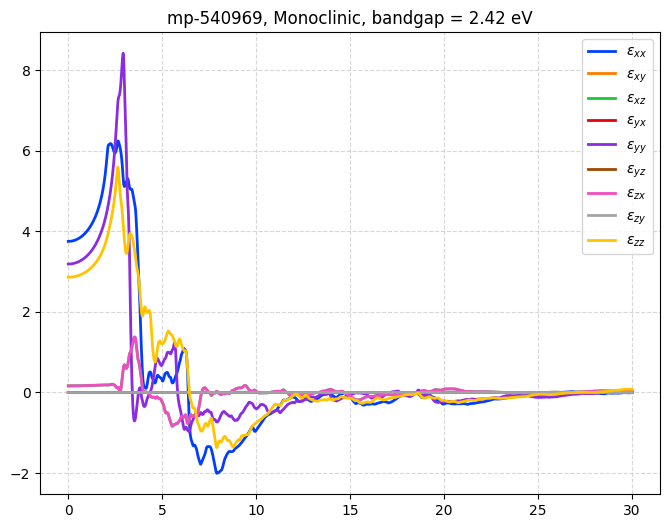

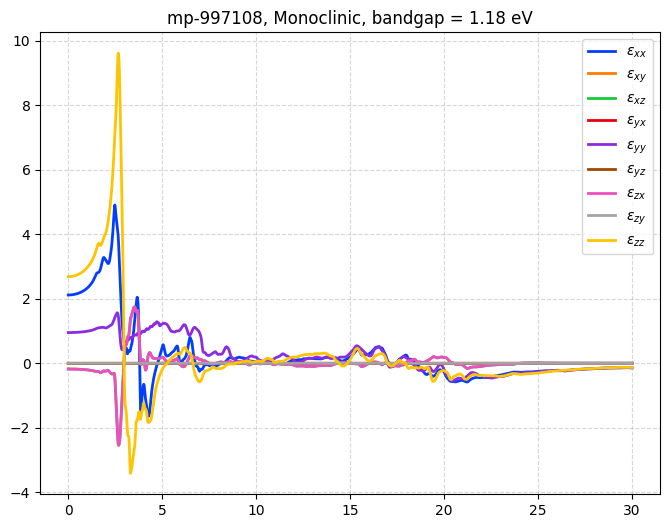

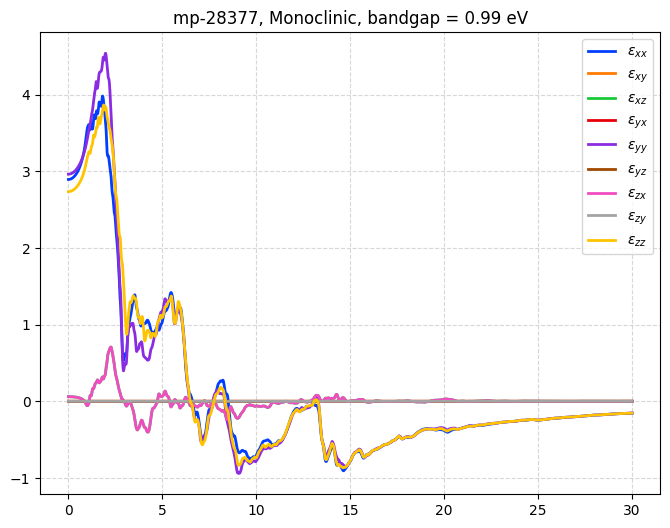

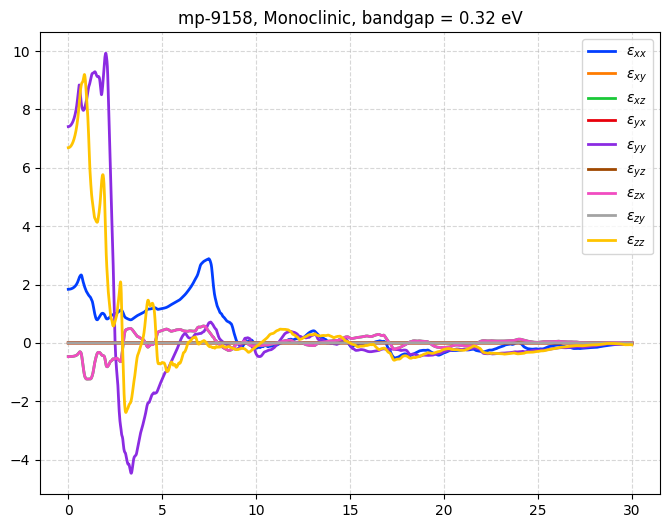

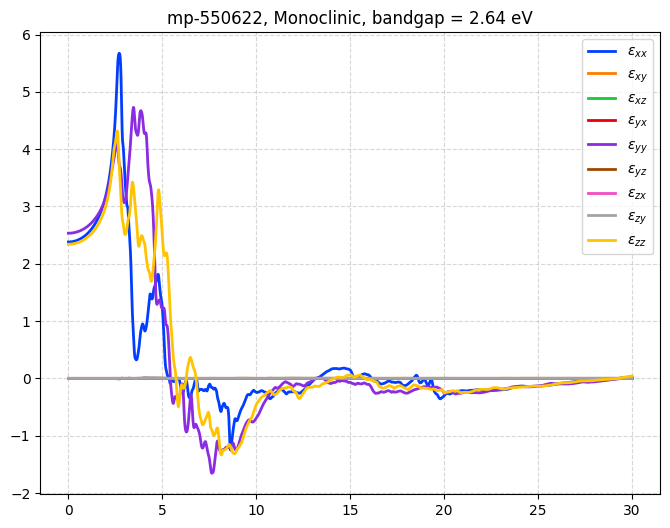

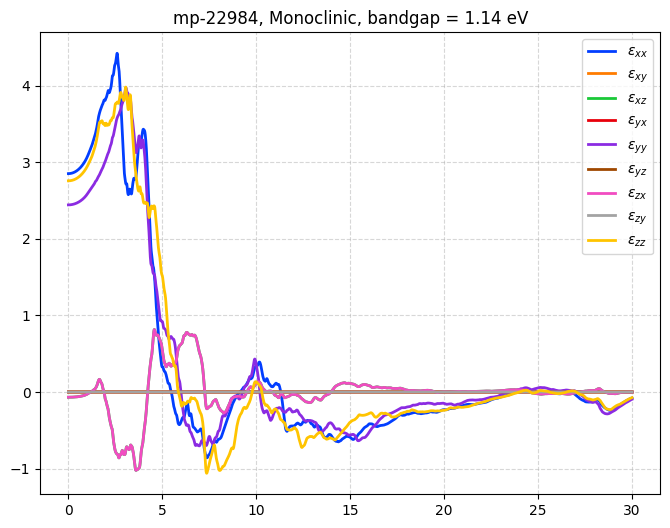

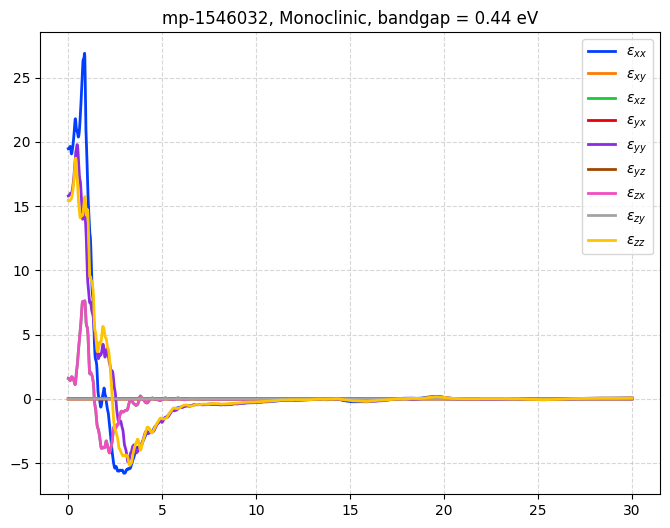

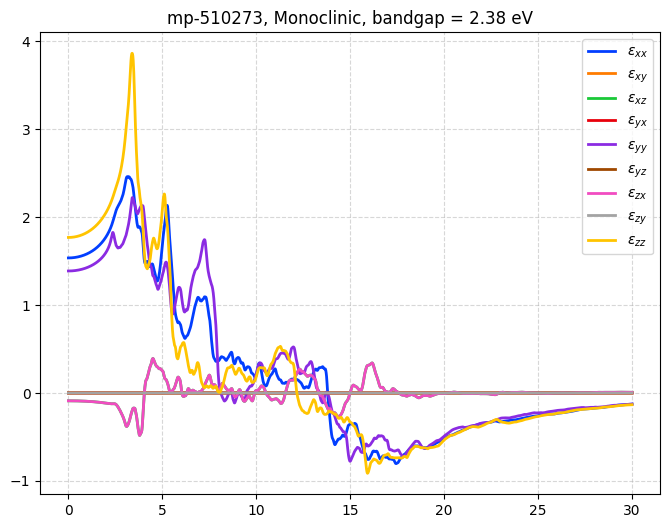

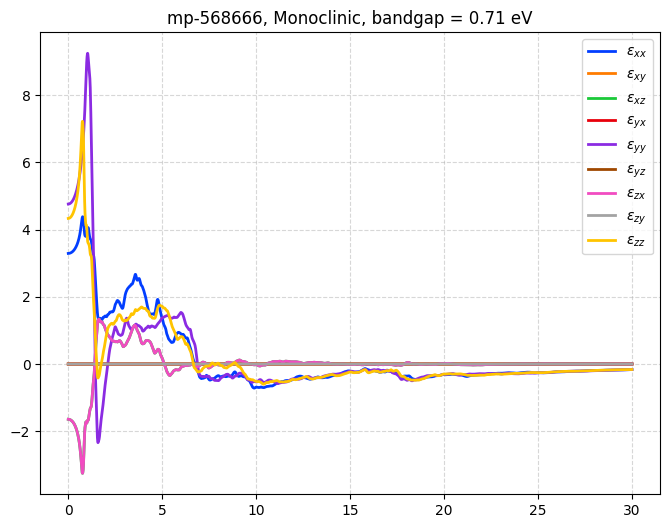

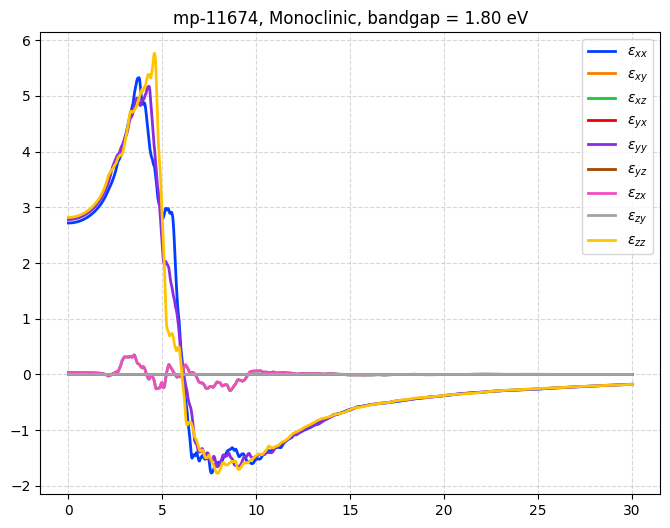

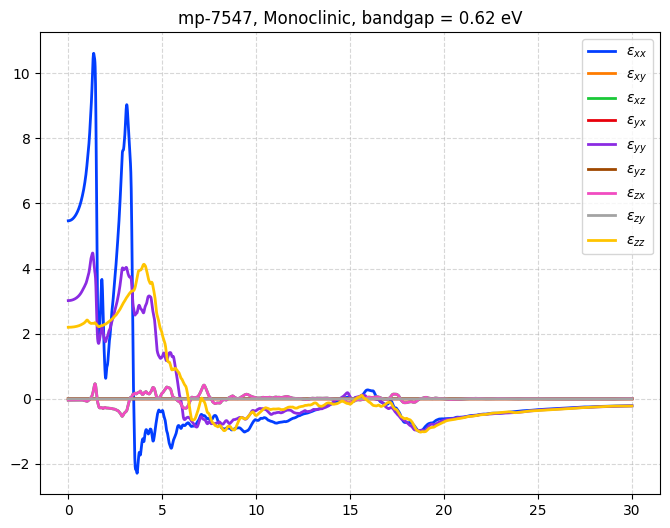

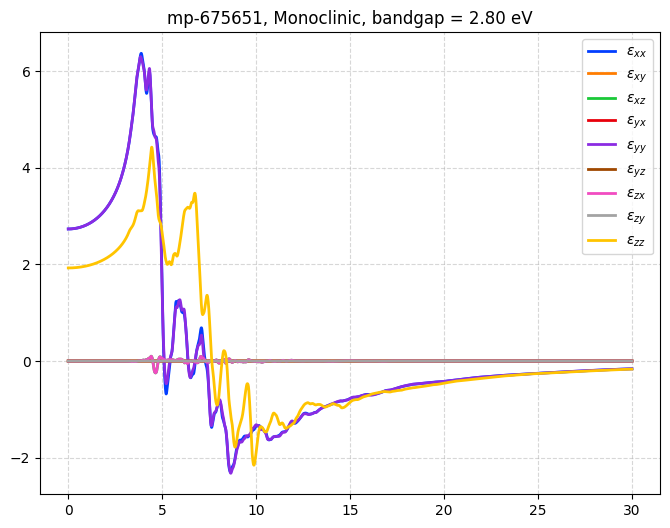

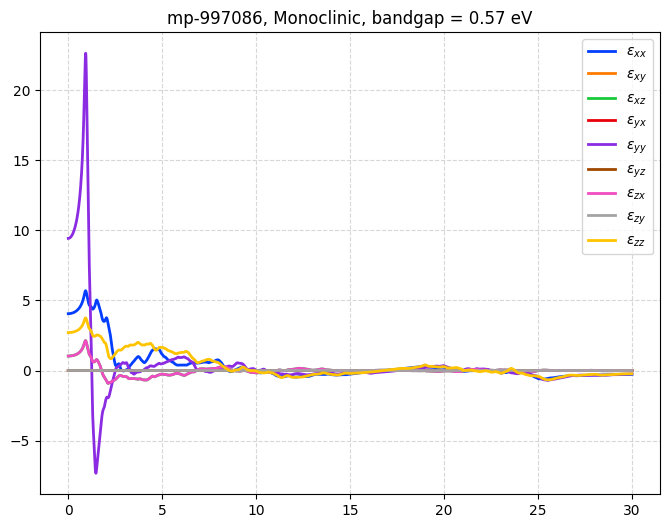

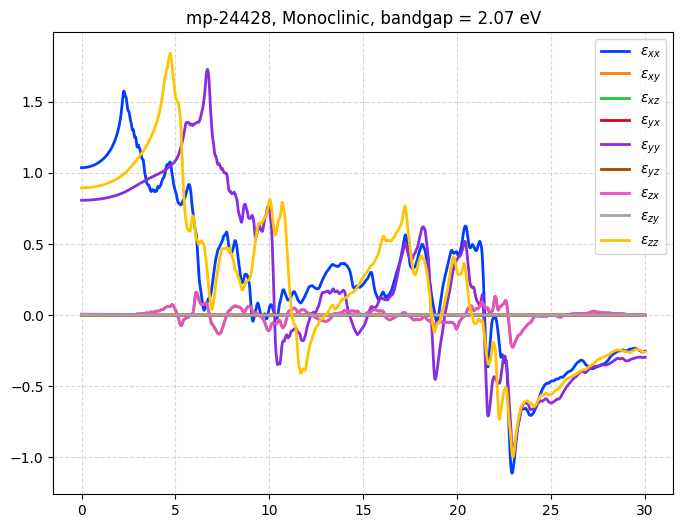

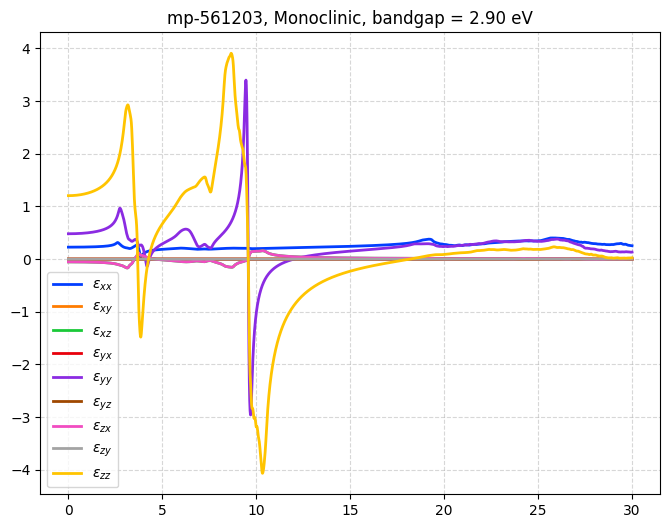

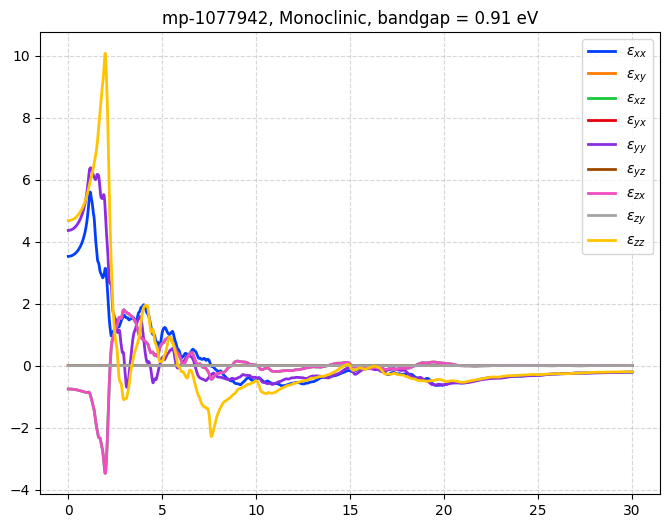

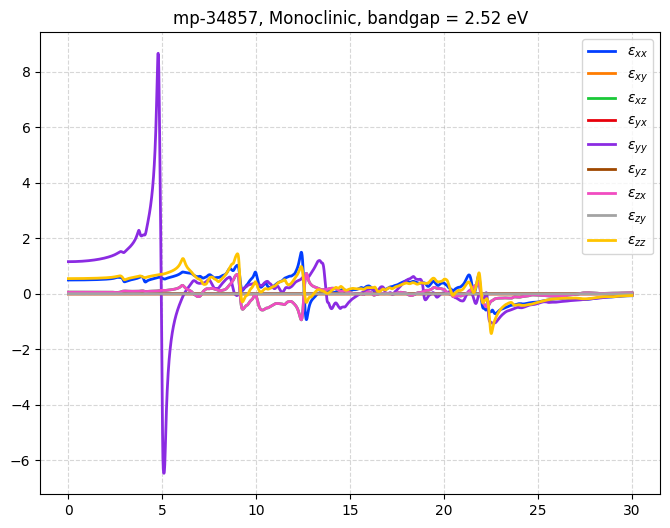

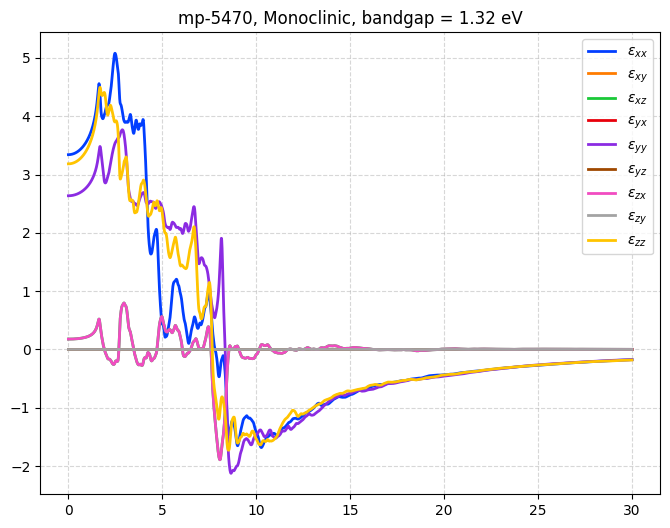

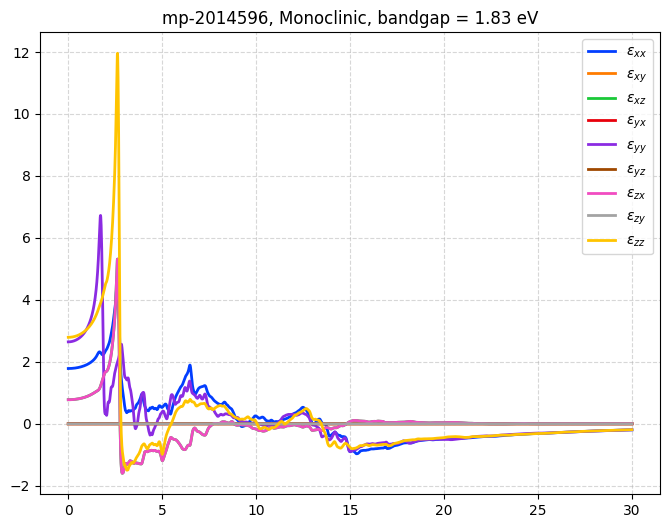

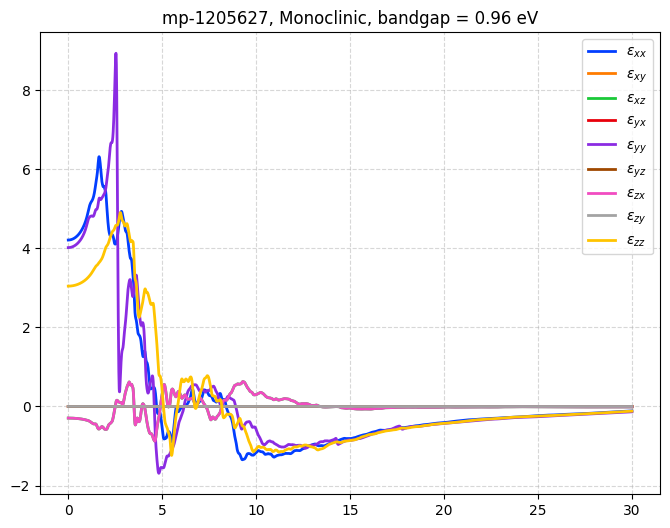

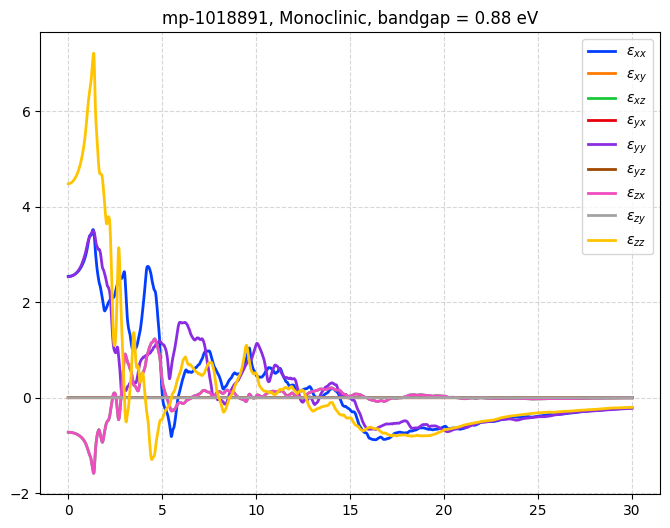

In [4]:
import seaborn as sns
import spglib
import matplotlib.pyplot as plt
def get_crystal_system(spacegroup_number):
    if 1 <= spacegroup_number <= 2:
        return "Triclinic"
    elif 3 <= spacegroup_number <= 15:
        return "Monoclinic"
    elif 16 <= spacegroup_number <= 74:
        return "Orthorhombic"
    elif 75 <= spacegroup_number <= 142:
        return "Tetragonal"
    elif 143 <= spacegroup_number <= 167:
        return "Trigonal"
    elif 168 <= spacegroup_number <= 194:
        return "Hexagonal"
    elif 195 <= spacegroup_number <= 230:
        return "Cubic"
    else:
        return "Unknown"
colors = sns.color_palette("bright", 9)  # Colorblind-friendly, distinct colors

# Select 10 random entries
random_samples = df[df["crystal_system"]=="monoclinic"].sample(n=30)
xyz_list = ["x", "y", "z"]
omega = df.iloc[0].omega  # Assuming omega is the same for all entries

for _, row in random_samples.iterrows():
    plt.figure(figsize=(8, 6),dpi=100)
    
    for i in range(3):
        for j in range(3):
            color = colors[(i * 3 + j) % len(colors)]  # Cycle through colors
            plt.plot(omega, row.real_symmetrized_permittivity[:, i, j], 
                     label=f"$\epsilon_{{{xyz_list[i]}{xyz_list[j]}}}$",  # Both indices as subscripts
                     color=color, linewidth=2)
    atoms = row.symmetrized_structure
    cell = (atoms.cell, atoms.get_scaled_positions(), atoms.numbers)
    spacegroup = spglib.get_spacegroup(cell, symprec=1e-3)  # Adjust symprec if needed
    spacegroup_number = spglib.get_symmetry_dataset(cell, symprec=1e-3)['number']
    crystal_system = get_crystal_system(spacegroup_number)

    plt.title(f"{row.mp_id}, {crystal_system}, bandgap = {row.bandgap:.2f} eV")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)  # Light dashed grid for readability
    plt.show()

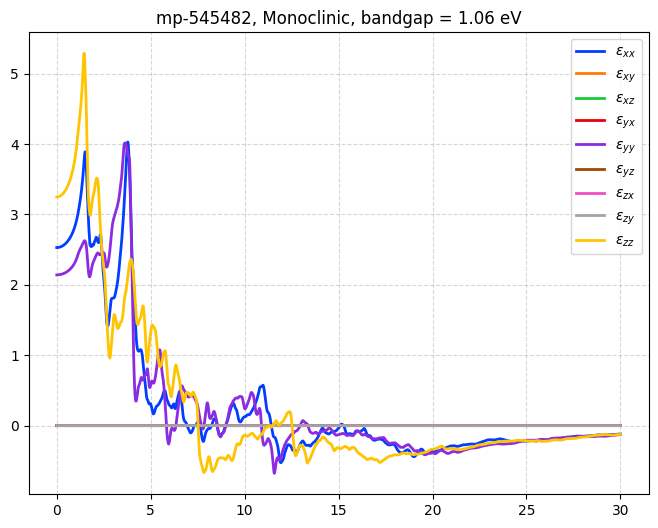

In [5]:
# Select 10 random entries
# target_sample = df[df["mp_id"]=="mp-1067154"]
# target_sample = df[df["mp_id"]=="mp-1185959"]
# target_sample = df[df["mp_id"]=="mp-33985"]
target_sample = df[df["mp_id"]=="mp-545482"]

xyz_list = ["x", "y", "z"]
omega = df.iloc[0].omega  # Assuming omega is the same for all entries

for _, row in target_sample.iterrows():
    plt.figure(figsize=(8, 6))
    
    for i in range(3):
        for j in range(3):
            color = colors[(i * 3 + j) % len(colors)]  # Cycle through colors
            plt.plot(omega, row.real_symmetrized_permittivity[:, i, j], 
                     label=rf"$\varepsilon_{{{xyz_list[i]}{xyz_list[j]}}}$", color=color, linewidth=2)
    atoms = row.symmetrized_structure
    cell = (atoms.cell, atoms.get_scaled_positions(), atoms.numbers)
    spacegroup = spglib.get_spacegroup(cell, symprec=1e-3)  # Adjust symprec if needed
    spacegroup_number = spglib.get_symmetry_dataset(cell, symprec=1e-3)['number']
    crystal_system = get_crystal_system(spacegroup_number)

    plt.title(f"{row.mp_id}, {crystal_system}, bandgap = {row.bandgap:.2f} eV")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)  # Light dashed grid for readability
    plt.show()